# Toxic Comment Detection Model #

# Import Data/Dependencies #

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.feature_extraction.text import TfidfVectorizer
import random

seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

In [3]:
df_1 = pd.read_csv("youtoxic_english_1000.csv")
df_2 = pd.read_csv("train.csv")

In [4]:
df_1.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


In [5]:
df_2.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Combining Data #

In [6]:
# Process the first DataSet
df1_adjusted = df_1[["Text", "IsToxic"]].copy()

# Process the second DataSet
df2_adjusted = df_2.loc[:, ["comment_text", "toxic"]].rename(columns={"comment_text": "Text", "toxic": "IsToxic"})

# Combine adjusted_df_1 and adjusted_df_2
df = pd.concat([df1_adjusted, df2_adjusted], ignore_index=True)

# Display the first few rows of final_df
print(df.head())

                                                Text  IsToxic
0  If only people would just take a step back and...        0
1  Law enforcement is not trained to shoot to app...        1
2  \nDont you reckon them 'black lives matter' ba...        1
3  There are a very large number of people who do...        0
4  The Arab dude is absolutely right, he should h...        0


# Visualization #

In [7]:
# Check data types and missing values
print(df.dtypes)
print(df.isnull().sum())

Text       object
IsToxic     int64
dtype: object
Text       0
IsToxic    0
dtype: int64


In [8]:
# Check for duplicate texts
duplicates = df[df.duplicated(subset='Text', keep=False)]

print("Duplicated texts:")
print(duplicates)

# Remove duplicates, keeping only the first occurrence
df = df.drop_duplicates(subset='Text', keep='first')

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

print("Data after removing duplicates:")
print(df)

Duplicated texts:
              Text  IsToxic
592  RUN THEM OVER        1
642  run them over        1
657  run them over        1
677  run them over        1
699  RUN THEM OVER        1
Data after removing duplicates:
                                                     Text  IsToxic
0       If only people would just take a step back and...        0
1       Law enforcement is not trained to shoot to app...        1
2       \nDont you reckon them 'black lives matter' ba...        1
3       There are a very large number of people who do...        0
4       The Arab dude is absolutely right, he should h...        0
...                                                   ...      ...
160563  ":::::And for the second time of asking, when ...        0
160564  You should be ashamed of yourself \n\nThat is ...        0
160565  Spitzer \n\nUmm, theres no actual article for ...        0
160566  And it looks like it was actually you who put ...        0
160567  "\nAnd ... I really don't think you u

In [9]:
# Distribution of 'Toxic' column
df['IsToxic'].value_counts()

IsToxic
0    144815
1     15753
Name: count, dtype: int64

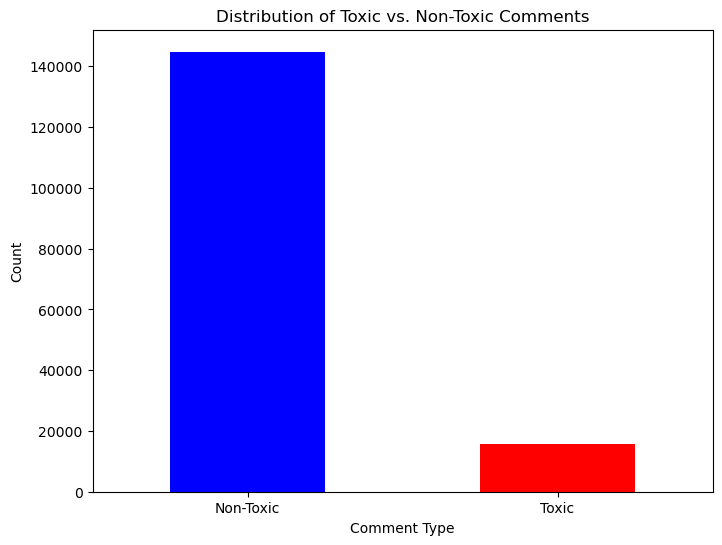

In [10]:
# Bar plot for toxic vs non-toxic comments

# Count the number of toxic and non-toxic comments
toxic_counts = df['IsToxic'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
toxic_counts.plot(kind='bar', color=['Blue', 'red'])
plt.title('Distribution of Toxic vs. Non-Toxic Comments')
plt.xlabel('Comment Type')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Toxic', 'Toxic'], rotation=0)
plt.show()


## Word Cloud for toxic and non-toxic comments ##

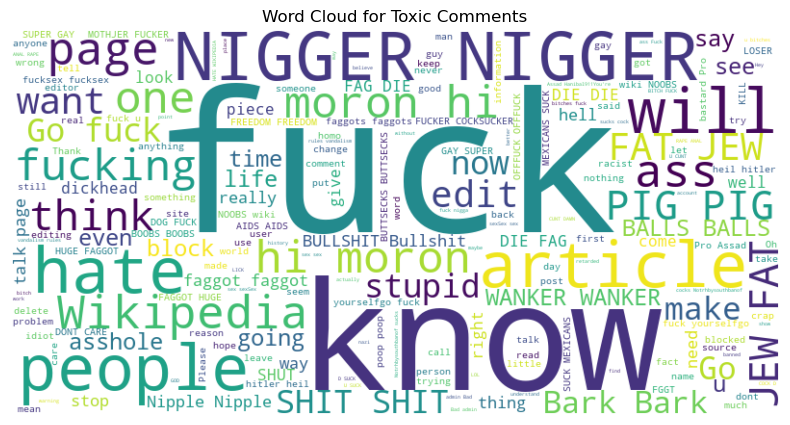

In [11]:
# Filter toxic comments
toxic_comments = df[df['IsToxic'] == True]

# Combine all toxic comments into a single string
toxic_text = " ".join(toxic_comments['Text'].tolist())

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=None).generate(toxic_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Comments')
plt.show()

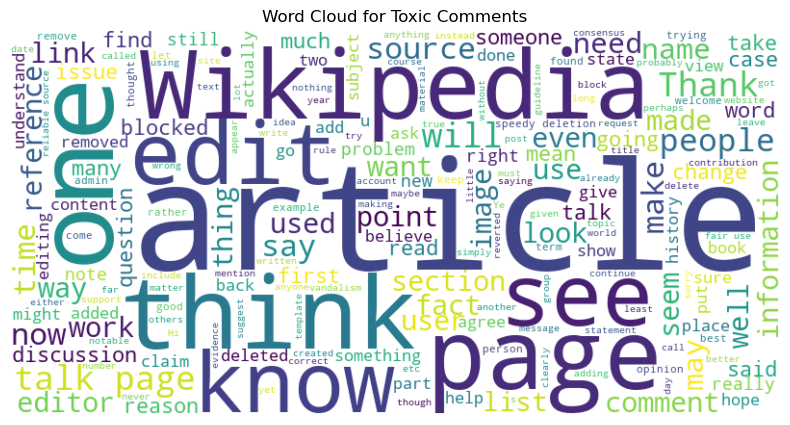

In [12]:
# Filter non-toxic comments
non_toxic_comments = df[df['IsToxic'] == False]

# Combine all non-toxic comments into a single string
non_toxic_text = " ".join(non_toxic_comments['Text'].tolist())

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=None).generate(non_toxic_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Comments')
plt.show()

## Transformation of Data ##

In [13]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Replace common contractions
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    
    # Replace URLs with a placeholder
    text = re.sub(r'http\S+|www\S+|https\S+', ' url ', text, flags=re.MULTILINE)
    
    # Replace mentions with a placeholder
    text = re.sub(r'@\w+', ' user ', text)
    
    # Replace hashtags with a placeholder
    text = re.sub(r'#\w+', ' hashtag ', text)
    
    # Replace emojis with a placeholder (optional)
    # Here is a simple regex for common emojis. For a comprehensive list, consider using an emoji library.
    text = re.sub(r'[^\w\s,]', '', text)
    
    # Replace numbers with a placeholder
    text = re.sub(r'\d+', ' number ', text)
    
    # Remove non-word characters and extra whitespace
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    
    # Trim leading and trailing whitespace
    text = text.strip()
    
    return text

In [14]:
df['Text'] = df['Text'].map(lambda com : clean_text(com))

In [15]:
df

,Text,IsToxic
0,if only people would just take a step back and...,0
1,law enforcement is not trained to shoot to app...,1
2,dont you reckon them black lives matter banner...,1
3,there are a very large number of people who do...,0
4,the arab dude is absolutely right he should ha...,0
...,...,...
160563,and for the second time of asking when your vi...,0
160564,you should be ashamed of yourself that is a ho...,0
160565,spitzer umm theres no actual article for prost...,0
160566,and it looks like it was actually you who put ...,0


## Vectorizer ## 

In [16]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the text data
X = vectorizer.fit_transform(df['Text'])
Y = df['IsToxic']

## Using SMOTE for class imbalance ## 

In [17]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Initialize SMOTE
smote = SMOTE()

# Apply SMOTE for oversampling
X_resampled, y_resampled = smote.fit_resample(X, Y)

In [18]:
# Check the distribution of classes before applying SMOTE
print("Before SMOTE:", Counter(Y))
# Check the distribution of classes after applying SMOTE
print("After SMOTE:", Counter(y_resampled))

Before SMOTE: Counter({0: 144815, 1: 15753})
After SMOTE: Counter({0: 144815, 1: 144815})


In [19]:
# Create a dataframe with the resampled data
df_resampled = pd.DataFrame(X_resampled.todense(), columns=vectorizer.get_feature_names_out())
df_resampled['Toxic'] = y_resampled

# Display the value counts of the target variable
value_counts = df_resampled['Toxic'].value_counts()

print(value_counts)

Toxic
0    144815
1    144815
Name: count, dtype: int64


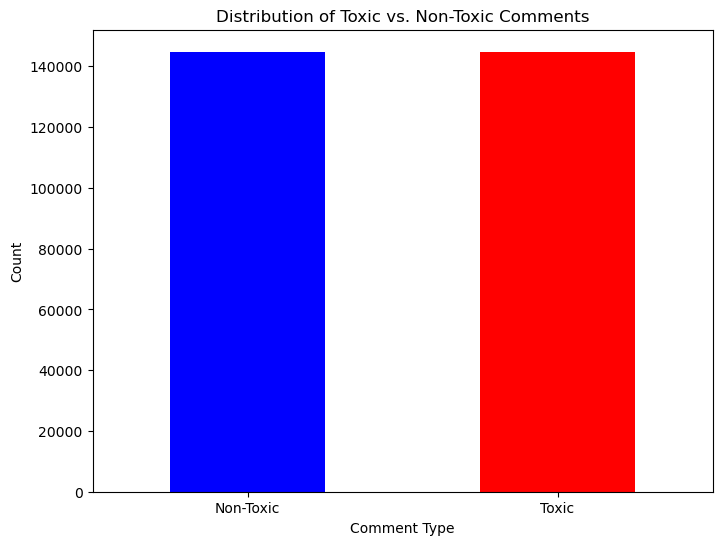

In [21]:
# Bar plot for toxic vs non-toxic comments

# Count the number of toxic and non-toxic comments
toxic_counts_after_sampler = df_resampled['Toxic'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
toxic_counts_after_sampler.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Toxic vs. Non-Toxic Comments')
plt.xlabel('Comment Type')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Toxic', 'Toxic'], rotation=0)
plt.show()


## Data Split ##

In [20]:
# Split the data for training
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

## Building the Model ##

In [22]:
# Build the neural network model with Input layer
model = tf.keras.Sequential([
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

## Training the Model 

In [23]:
# Train the model
history = model.fit(x_train.toarray(), y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
5793/5793 [==============================] - 7s 1ms/step - loss: 0.2346 - accuracy: 0.9121 - val_loss: 0.1873 - val_accuracy: 0.9279
Epoch 2/5
5793/5793 [==============================] - 6s 971us/step - loss: 0.1649 - accuracy: 0.9386 - val_loss: 0.1591 - val_accuracy: 0.9412
Epoch 3/5
5793/5793 [==============================] - 6s 968us/step - loss: 0.1341 - accuracy: 0.9523 - val_loss: 0.1370 - val_accuracy: 0.9515
Epoch 4/5
5793/5793 [==============================] - 6s 966us/step - loss: 0.1126 - accuracy: 0.9616 - val_loss: 0.1203 - val_accuracy: 0.9593
Epoch 5/5
5793/5793 [==============================] - 6s 969us/step - loss: 0.0970 - accuracy: 0.9680 - val_loss: 0.1100 - val_accuracy: 0.9633


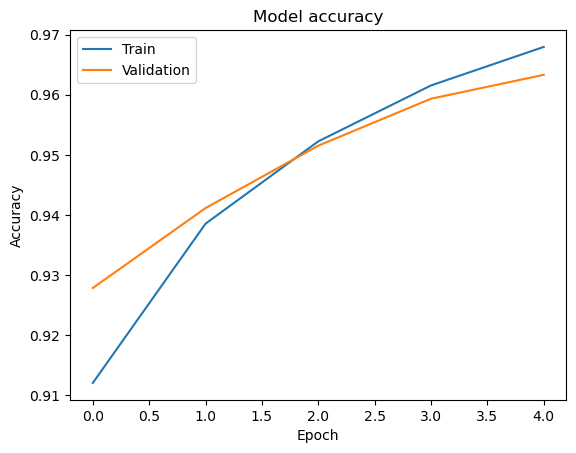

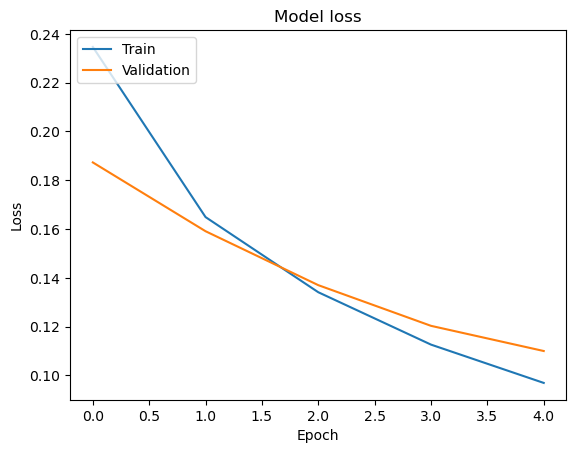

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Evaluation of Model ##

In [26]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test.toarray(), y_test)
print(f'Test Accuracy: {accuracy}')

1811/1811 [==============================] - 1s 470us/step - loss: 0.1083 - accuracy: 0.9635
Test Accuracy: 0.9634706377983093


In [28]:
from sklearn.metrics import classification_report

# Generate predictions on the test set
y_pred_proba = model.predict(x_test.toarray())
y_pred = (y_pred_proba > 0.5).astype(int)

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

1811/1811 [==============================] - 1s 422us/step
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     28835
           1       0.95      0.98      0.96     29091

    accuracy                           0.96     57926
   macro avg       0.96      0.96      0.96     57926
weighted avg       0.96      0.96      0.96     57926



## Save the Model ##

In [36]:
import pickle
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save Keras model
model.save('toxic_comment_model.h5')